In [1]:
# Importing packages 
import time 
import numpy as np
import os
import pickle
os.environ['CUDA_VISIBLE_DEVICES'] = '-1' # To disable trainning in GPU
import tensorflow as tf 
tf.get_logger().setLevel(tf._logging.ERROR)

# Data Loader 
from Data.data_loader import create_train_dataset_memae  # Trainning dataset loader for MemAE model 
from Data.data_loader import create_test_dataset_memae  # Trainning dataset loader for MemAE model 


# Importing the models 
from Models.MemAE.model import AE
from Models.MemAE.model import MemAE

# Importing trainning function 
# from Models.MemAE.train import train_ae
from Models.MemAE.train import train_memae

# Loss function 
# from  Models.MemAE.loss import reconstruct_error
# from  Models.MemAE.loss import MemAELoss

# Visualization functions 
from Utils.visualization import plot_two_images,plot_result
from Utils.plots import plot_loss_evol,plot_metric_evol

2023-07-17 19:35:08.108101: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-17 19:35:08.942345: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# Tensorflow config 
tf.config.list_physical_devices()
tf.config.threading.set_inter_op_parallelism_threads(12) 
tf.config.threading.set_intra_op_parallelism_threads(12)
tf.config.set_soft_device_placement(False)

2023-07-17 19:35:11.057642: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2023-07-17 19:35:11.057805: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:168] retrieving CUDA diagnostic information for host: OSIL
2023-07-17 19:35:11.057816: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:175] hostname: OSIL
2023-07-17 19:35:11.058096: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:199] libcuda reported version is: 535.54.3
2023-07-17 19:35:11.058142: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:203] kernel reported version is: 535.54.3
2023-07-17 19:35:11.058150: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:309] kernel version seems to match DSO: 535.54.3


### Loading data

In [4]:
# Dimensions of data 
#* PED2 are 3:2
H = 128 # 192
W = 192 # 128
nb_frames = 16

In [5]:
#* Loading trainning dataset for MemAE model 
data_train = create_train_dataset_memae(H,W,nb_frames,load_ped2 = True ,load_ped1=False,shuffle=False,m=154,save=True,save_path='./Data/Data_npy',path_ped2='./Data/UCSDped2',path_ped1='./Data/UCSDped1')
#* Loading the test data 
data_test,data_test_gt,data_test_labels = create_test_dataset_memae(H,W,nb_frames,load_ped2 = True ,load_ped1=False,save=True,save_path='./Data/Data_npy',path_ped2='./Data/UCSDped2',path_ped1='./Data/UCSDped1')




<<<  Loading trainning dataset >>>
path : ./Data/Data_npy/train_(154, 16, 128, 192, 1).npy
Dataset alreardy prepared, loading it
Data loaded , shape (154, 16, 128, 192, 1), size 462.0 MB 


<<<  Loading testing dataset >>>
path data : ./Data/Data_npy/test_data_(122, 16, 128, 192, 1).npy
path data gt : ./Data/Data_npy/test_data_gt_(122, 16, 128, 192, 1).npy
path data labels: ./Data/Data_npy/test_data_labels_(122, 16, 128, 192, 1).npy
Dataset alreardy prepared, loading it
Data loaded , shape  data (122, 16, 128, 192, 1), gt data (122, 16, 192, 128, 1), labels (122, 16) size 45.77978515625 MB 



## Training the model  

### Model and training parameters 

In [6]:
#? Parameters of the model 
learning_rate = 0.0002 #0.0001/0.0002 gave good results 
nb_epochs = 60
mem_dim = 2000
entropy_loss = 0.002 # 0.002 goood res , 0.002  / 0.0002
shrink_thresh = 0.0005 #0.0025  0.001 0.0015 0.0005 0.0004
batch_size = 5

### History params 

In [7]:
#? History params 
history_params = {
            "dir" : f"./Training_History/MemAE_{H}_{W}", # Folder in which save the data  
            "train_params" : {
                "train_data_shape": data_train.shape,
                "test_data_shape" : data_test.shape,
                "learning_rate" : learning_rate, 
                "nb_epochs" : nb_epochs,
                "mem_dim" :mem_dim,
                "entropy_loss" : entropy_loss, 
                "shrink_thresh" :shrink_thresh,
                "batch_size":batch_size
            },
            "nb_epochs_checkpoint" : 10,  # Checkpoint (saving weights and optimizer state) each .. epochs 
        }

In [7]:
#? Deleting older records 
!rm -r "./Training_History"
!mkdir "./Training_History"

/bin/bash: /home/osil/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/osil/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)


### Optimizer 

In [8]:
# Creation of a new optimizer 
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

# Loading an old optimizer 
# with open("./Trainning_History/MemAE/Weights/optimizer_epoch_2.pkl", "rb") as file:
#     optimizer_config = pickle.load(file)
#     optimizer =tf.keras.optimizers.Adam().from_config(optimizer_config)


### Model 

In [8]:
memae_model = MemAE((None,nb_frames,H,W,1),nb_items=mem_dim,
                        delta=shrink_thresh)
memae_model.build((None,nb_frames,H,W,1))
memae_model.summary()

(None, 16, 128, 192, 1)
(None, 2, 8, 12, 1)
Model: "MemAE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Encoder (Encoder)           multiple                  2992256   
                                                                 
 Memory (Memory)             multiple                  512000    
                                                                 
 Decoder (Decoder)           multiple                  2990977   
                                                                 
Total params: 6495233 (24.78 MB)
Trainable params: 6492801 (24.77 MB)
Non-trainable params: 2432 (9.50 KB)
_________________________________________________________________


## Training the model 
* To check the memory usage *top -o %MEM*

In [ ]:
train_losses,val_losses,eval_metrics = train_memae(memae_model,data_train,optimizer,
                validation_data=data_test[5:10,:,:,:,:],
                evaluation_metric=None,epochs=nb_epochs,batch_size=batch_size,
                record_history=True,history_params=history_params)


<<<  Trainning   >>>
Shape of data : (154, 16, 256, 256, 1)
Size of a batch : 5   Number of batchs = 30
Number of epochs : 20

Start of epoch 1 


2023-07-16 23:49:56.390484: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 503316480 exceeds 10% of free system memory.
2023-07-16 23:49:56.709572: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 503316480 exceeds 10% of free system memory.
2023-07-16 23:49:56.984655: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 584064000 exceeds 10% of free system memory.
2023-07-16 23:49:59.354634: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 503316480 exceeds 10% of free system memory.
2023-07-16 23:49:59.355099: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 339738624 exceeds 10% of free system memory.


Btach 0/30  loss= 0.23030829429626465
Btach 1/30  loss= 0.23261098563671112
Btach 2/30  loss= 0.22986063361167908
Btach 3/30  loss= 0.22813355922698975
Btach 4/30  loss= 0.22686704993247986
Btach 5/30  loss= 0.22686314582824707
Btach 6/30  loss= 0.2268572300672531
Btach 7/30  loss= 0.22580230236053467


In [ ]:
# Saving the weights 
memae_model.save_weights("./Models/memae_model_weights_(256,256).h5")


In [9]:
# Loading weights 
memae_model.load_weights("./Models/Models_weights_save/memae_model_weights_({H},{W}).h5")


### Plotting the results

In [ ]:
plot_loss_evol(train_losses,val_losses)


## Testing  

In [12]:
# Computing a test image
in_img = data_train[8:9,:,:,:,:]
out_img = memae_model(in_img)[0]
rec_error = (in_img-out_img)**2
anomaly_mask = np.where(rec_error.numpy() > 0.05 , 1, 0)

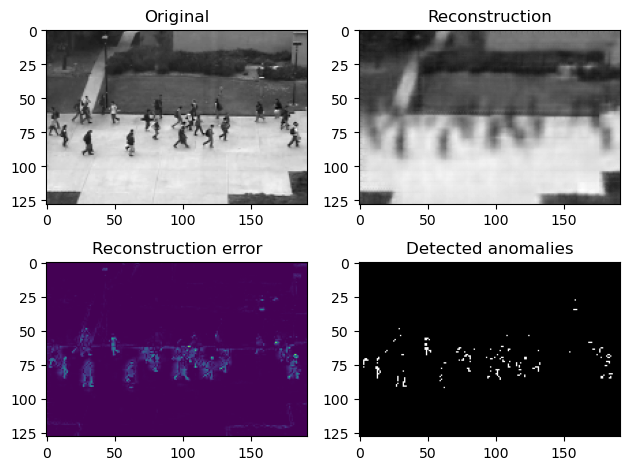

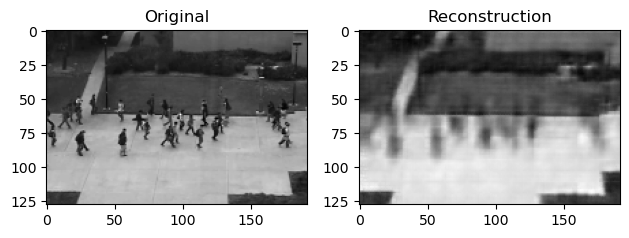

In [13]:
plot_result(in_img[0,-1,:,:,:],out_img[0,-1,:,:,:],rec_error[0,-1,:,:,:],anomaly_mask[0,-1,:,:,:],save=True,filename='/media/osil/Secondary/_Stage_CERIST/Documentation_Paper/images/MemAE/ae_results.png')
plot_two_images(in_img[0,2,:,:,0],out_img[0,2,:,:,0])